In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Input
from keras.models import Model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn.model_selection import train_test_split


In [2]:
#thomas
# Upload faulty training dataset
df = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_Faulty_Training.csv', on_bad_lines='skip')

# Upload the fault-free training dataset
df2 = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_FaultFree_Training.csv', on_bad_lines='skip')

# Upload the faulty testing dataset
df_test = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_Faulty_Testing.csv', on_bad_lines='skip')

# Upload the fault-free training dataset
df2_test = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_FaultFree_Testing.csv', on_bad_lines='skip')

In [3]:
#Sub-sample (20)
df = df.loc[(df['simulationRun']<21),:]
df2 = df2.loc[(df2['simulationRun']<21),:]

df_test = df_test.loc[(df_test['simulationRun']<21),:]
df2_test = df2_test.loc[(df2_test['simulationRun']<21),:]

#Combine Test data
combined_df_test = pd.concat([df_test, df2_test], ignore_index=True)

#Combine Training data
combined_df = pd.concat([df, df2], ignore_index=True)

In [5]:
#EDA FOR RF
features_to_plot = ['xmeas_2','xmeas_5', 'xmeas_12', 'xmeas_14', 'xmeas_15', 'xmeas_17', 'xmeas_37','xmv_7', 'xmv_8']

def featureengg(combined_df, features_to_plot):

    # Assuming combined_df, features_to_plot are defined earlier
    clean_df = combined_df.drop(columns=features_to_plot).copy()

    window_size = 20  #Window size
    j = [2, 4, 6, 8]  # Lag intervals

    new_columns = defaultdict(list)

    # Loop through faults and runs
    for fault in clean_df['faultNumber'].unique():
        for run in clean_df[clean_df['faultNumber'] == fault]['simulationRun'].unique():
            mask = (clean_df['faultNumber'] == fault) & (clean_df['simulationRun'] == run)

            for feature in clean_df.columns.difference(['faultNumber', 'simulationRun', 'sample']):
                frequency_feat = [np.nan] * len(clean_df.loc[mask, feature])
                feature_ma = f'{feature}_MA'
                feature_std = f'{feature}_STD'

                # Calculate moving average and standard deviation
                ma = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).mean()
                std = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).std()


                new_columns[feature_ma].extend(ma)
                new_columns[feature_std].extend(std)

                # Calculate and store lagged features
                for i in j:
                    lag_name = f'{feature}_lag{i}'
                    lag = clean_df.loc[mask, feature].shift(i)
                    new_columns[lag_name].extend(lag)

                #Calculate the FFT
                feature_f = f'{feature}_frequency'
                for i in range(len(clean_df.loc[mask, feature])):
                    if i < window_size:
                        frequency_feat[i] = np.nan
                    else:
                        frequency_feat[i] = np.abs(np.fft.fft(clean_df.loc[mask, feature][i-window_size:i])[1:]).max()

                new_columns[feature_f].extend(frequency_feat)

    for key in new_columns:
        new_columns[key] = pd.Series(new_columns[key], index=clean_df.index)

    new_columns_df = pd.DataFrame(new_columns)
    clean_df = pd.concat([clean_df, new_columns_df], axis=1)
    return clean_df

In [6]:
#Feature engineering of Training Data
clean_df = featureengg(combined_df, features_to_plot)

#For Binary classification
clean_df_cleaned = clean_df.dropna(axis=0)
clean_df_cleaned['faultNumber'] = (clean_df_cleaned['faultNumber'] > 0).astype(int)
comb_x_df = clean_df_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df = clean_df_cleaned['faultNumber']

#Feature engineering of Testing Data
clean_df_test = featureengg(combined_df_test, features_to_plot)

#For Binary classification
clean_df_test_cleaned = clean_df_test.dropna(axis=0)
clean_df_test_cleaned['faultNumber'] = (clean_df_test_cleaned['faultNumber'] > 0).astype(int)
comb_x_df_test = clean_df_test_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df_test = clean_df_test_cleaned['faultNumber']

C:\Users\kamin\AppData\Local\Temp\ipykernel_20800\1317679147.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_cleaned['faultNumber'] = (clean_df_cleaned['faultNumber'] > 0).astype(int)
C:\Users\kamin\AppData\Local\Temp\ipykernel_20800\1317679147.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_test_cleaned['faultNumber'] = (clean_df_test_cleaned['faultNumber'] > 0).astype(int)


In [7]:
#For Binary classification

A1 = Pipeline([('A_',StandardScaler(with_mean=False))])
clf = RandomForestClassifier(n_estimators=200, max_depth=40)

full_pipeline_Kbest = Pipeline([('initial_transform', A1), ('RFR', clf)])
X_new=full_pipeline_Kbest.fit(comb_x_df, comb_y_df)

Accuracy: 0.9705297619047619


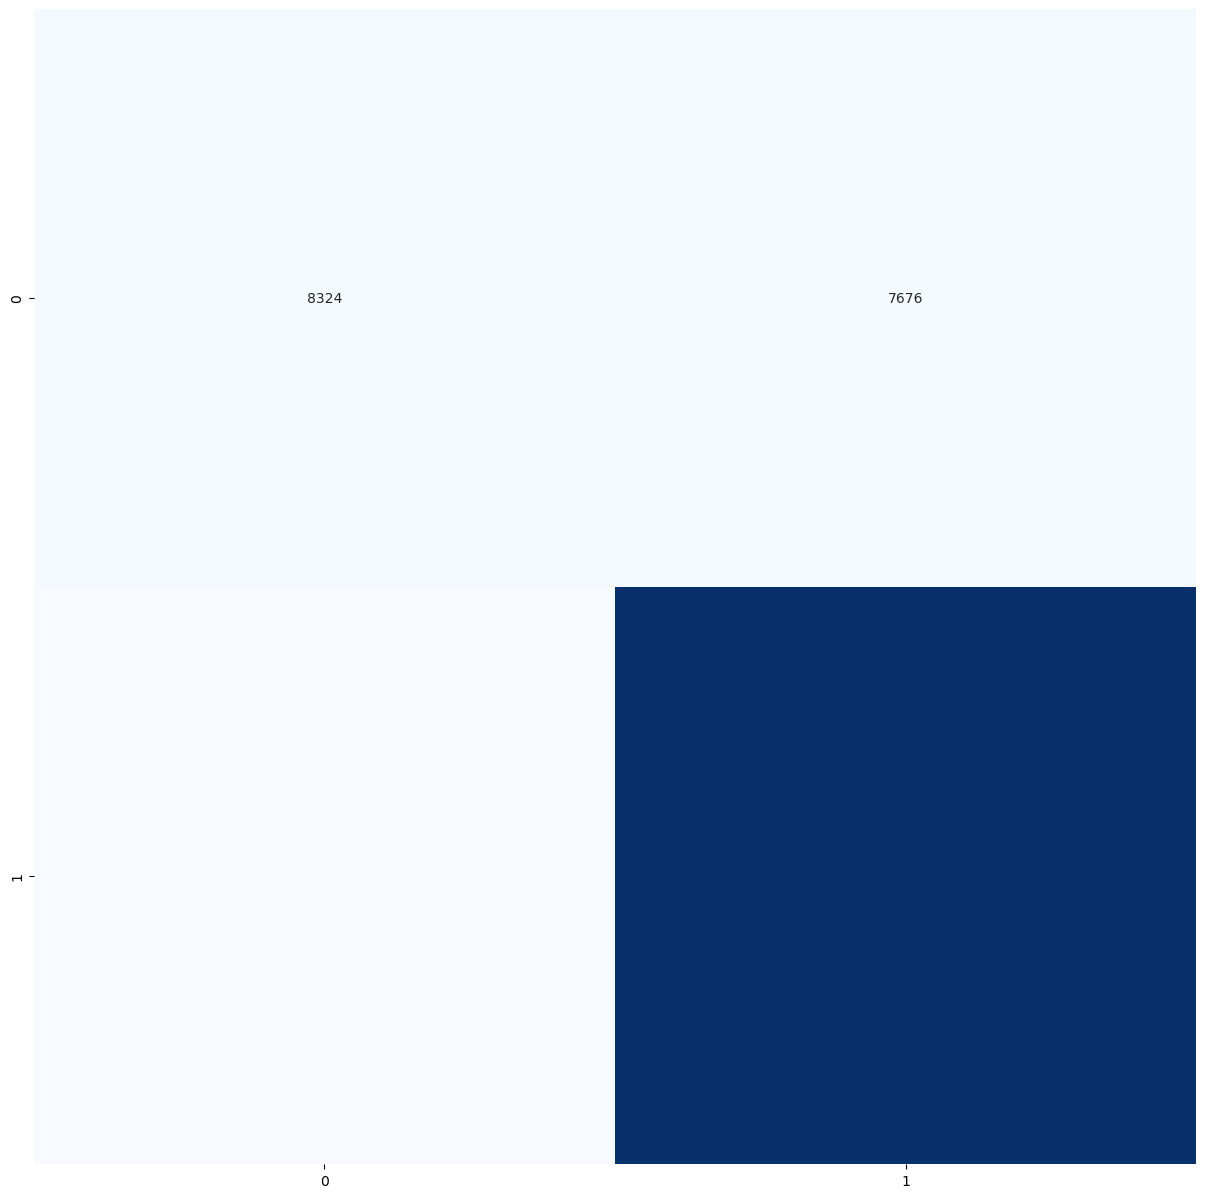

Precision: 0.843129435505564
Recall: 0.83983789260385
F1-Score: 0.7947445527158744
Accuracy: 0.83983789260385
        Actual  Predicted  Correct  sample  simulationRun
20           0          1     True      21              1
21           0          1     True      22              1
22           0          1     True      23              1
23           0          1     True      24              1
24           0          1     True      25              1
...        ...        ...      ...     ...            ...
403195       0          1    False     956             20
403196       0          1    False     957             20
403197       0          1    False     958             20
403198       0          1    False     959             20
403199       0          1    False     960             20

[394800 rows x 5 columns]


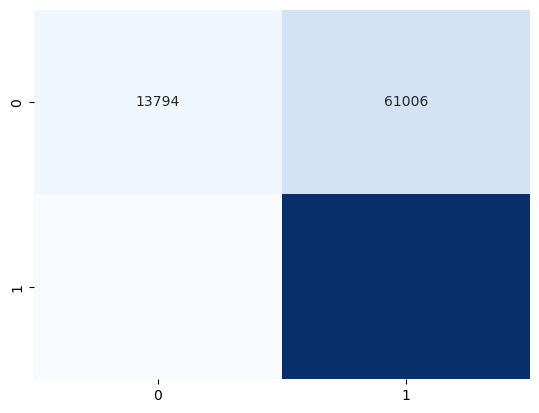

In [8]:
#Results for binary model
predictions = full_pipeline_Kbest.predict(comb_x_df_test)
results_df = pd.DataFrame({
    'Actual': comb_y_df_test,
    'Predicted': predictions,
    'Correct': comb_y_df_test == predictions,
})


results_df['sample'] = clean_df_test_cleaned['sample']
results_df['simulationRun'] = clean_df_test_cleaned['simulationRun']

plt.figure(figsize=(15, 15))
conf_matrix = confusion_matrix(results_df.loc[results_df['sample']>160,'Actual'],
                               results_df.loc[results_df['sample']>160,'Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

accuracy = accuracy_score(results_df.loc[results_df['sample']>160,'Actual'],
                               results_df.loc[results_df['sample']>160,'Predicted'])
print(f"Accuracy: {accuracy}")

plt.show()
anotherone = results_df.loc[results_df['sample']>160].groupby(['Actual']).agg({'Predicted':'count', 'Correct':'sum'})
anotherone['accuracy'] = anotherone['Correct']/anotherone['Predicted']

results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
conf_matrix =confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")

anotherone = results_df.loc[results_df['sample']>160].groupby(['Actual']).agg({'Predicted':'count', 'Correct':'sum'})
anotherone['accuracy'] = anotherone['Correct']/anotherone['Predicted']

print(results_df)

Precision: 0.8428510201358267
Recall: 0.8398404255319148
F1-Score: 0.7948568370715551
Accuracy: 0.8398404255319148


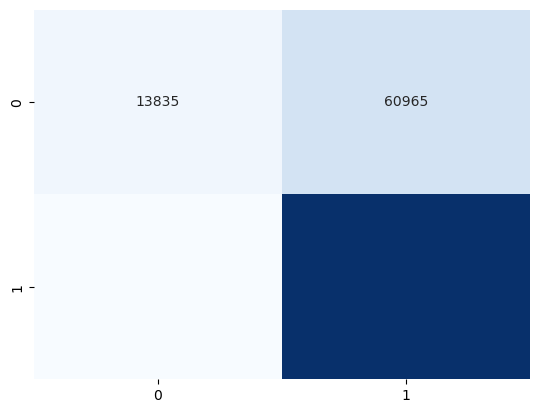

In [12]:
#More results for binary model
results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
conf_matrix =confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")

In [9]:
filtered_results_df = results_df[results_df['Actual'] == results_df['Predicted']]
filtered_results_df.head()

,Actual,Predicted,Correct,sample,simulationRun
28,0,0,False,29,1
29,0,0,False,30,1
30,0,0,False,31,1
31,0,0,False,32,1
32,0,0,False,33,1


In [10]:
# Get the index from filtered_results_df
filtered_index = filtered_results_df.index

# Filter combined_df_test using the index
filtered_combined_df_test = combined_df_test.loc[filtered_index]

In [21]:
# Splitting the dataset into train and test sets
train = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\train.csv', on_bad_lines='skip')
cv = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\cv.csv', on_bad_lines='skip')
test = filtered_combined_df_test

# Removing faults 3, 9, and 15
tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15)].index).reset_index()
cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15)].index).reset_index()

# Map fault numbers to a new continuous range
mapping = {0:0, 1:1, 2:2, 4:3, 5:4, 6:5, 7:6, 8:7, 10:8, 11:9, 12:10, 13:11, 14:12, 16:13, 17:14, 18:15, 19:16, 20:17}
tr['mappedFaultNumber'] = tr['faultNumber'].map(mapping)
ts['mappedFaultNumber'] = ts['faultNumber'].map(mapping)
cv_['mappedFaultNumber'] = cv_['faultNumber'].map(mapping)

 # Column names to drop
columns_to_drop = tr.columns[27:46]

# Drop the columns from the dataframes
cv_.drop(cv.columns[0], axis=1, inplace=True)
tr.drop(cv.columns[0], axis=1, inplace=True)
tr.drop(columns_to_drop, axis=1, inplace=True)
ts.drop(columns_to_drop, axis=1, inplace=True)
cv_.drop(columns_to_drop, axis=1, inplace=True)

In [22]:
def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_train = []
Y_train = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 18):  # Iterating correctly from 0 to 17
    max_runs = 40 if j == 0 else 25  # Assuming faultNumber 0 is fault-free
    for i in range(1, max_runs + 1):  # Iterate over the correct number of simulation runs
        df = tr[(tr['mappedFaultNumber'] == j) & (tr['simulationRun'] == i)]
        x_temp, y_temp = SlidingWindow(df, w, s)
        X_train.extend(x_temp)
        Y_train.extend(y_temp)

# Convert X and Y to numpy arrays and reshape X for LSTM
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = X_train.reshape(-1, w, X_train.shape[-1])
X_train.shape, Y_train.shape


((21935, 20, 32), (21935,))

In [23]:
# Initialize a StandardScaler object
sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
reduced_data = tr[tr['faultNumber']==0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = reduced_data[(reduced_data['faultNumber'] == 0)].iloc[:, 5:-1]

# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)

X_train_sc = sc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc.fit(Y_train.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_train_enc = enc.transform(Y_train.reshape(-1, 1))

c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_test = []
Y_test = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 18):  # Iterating correctly from 0 to 17
    max_runs = 3 if j == 0 else 10  # Assuming faultNumber 0 is fault-free
    for i in range(1, max_runs + 1):  # Iterate over the correct number of simulation runs
        df = ts[(ts['mappedFaultNumber'] == j) & (ts['simulationRun'] == i)]
        x_temp, y_temp = SlidingWindow(df, w, s)
        X_test.extend(x_temp)
        Y_test.extend(y_temp)

# Convert X and Y to numpy arrays and reshape X for LSTM
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = X_test.reshape(-1, w, X_test.shape[-1])

X_test.shape, Y_test.shape


((13644, 20, 32), (13644,))

In [25]:
def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_cv = []
Y_cv = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 18):  # Iterating correctly from 0 to 17
    if j == 0:
        max_runs = 20  # Assuming faultNumber 0 is fault-free
        for i in range(41, max_runs + 41):  # Iterate over the correct number of simulation runs
            df = cv_[(cv_['mappedFaultNumber'] == j) & (cv_['simulationRun'] == i)]
            x_temp, y_temp = SlidingWindow(df, w, s)
            X_cv.extend(x_temp)
            Y_cv.extend(y_temp)
    else:
        max_runs = 10
        for i in range(26, max_runs + 26):  # Iterate over the range 26 to max_runs
            df = cv_[(cv_['mappedFaultNumber'] == j) & (cv_['simulationRun'] == i)]
            x_temp, y_temp = SlidingWindow(df, w, s)
            X_cv.extend(x_temp)
            Y_cv.extend(y_temp)


# Convert X and Y to numpy arrays and reshape X for LSTM
X_cv = np.array(X_cv)
Y_cv = np.array(Y_cv)
X_cv = X_cv.reshape(-1, w, X_cv.shape[-1])

X_cv.shape, Y_cv.shape


((8970, 20, 32), (8970,))

In [26]:
X_test_sc = sc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_cv_sc = sc.transform(X_cv.reshape(-1, X_cv.shape[-1])).reshape(X_cv.shape)

# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc_1 = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc_1.fit(Y_test.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_test_enc = enc_1.transform(Y_test.reshape(-1, 1))

# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc_2 = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc_2.fit(Y_cv.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_cv_enc = enc_2.transform(Y_cv.reshape(-1, 1))

c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\kamin\miniconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [27]:
def LSTM_model(X_train,y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(LSTM(128,activation="tanh",return_sequences=True))(input_layer)
    encoded = LSTM(128, activation="tanh")(encoded)

    # Define decoder layers
    decoded = Dense(300, activation='selu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='softmax')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)
    # Compile LSTM  model
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return lstm_model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 32)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          164864    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 18)                5418      
                                                             

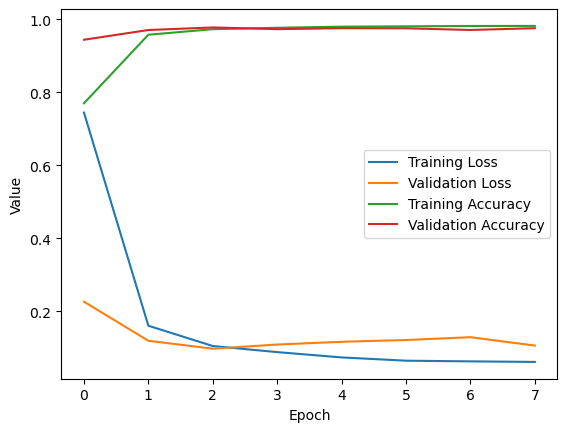

In [28]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = LSTM_model(X_train_sc,Y_train_enc)
model.summary()
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(X_train_sc, Y_train_enc, epochs=200, batch_size=256, validation_data=(X_cv_sc, Y_cv_enc), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [29]:
# Define your custom class labels
custom_labels = ['0', '1', '2', '4', '5', '6', '7', '8', '10,','11', '12', '13', '14', '16', '17', '18', '19','20']

# Create a function to plot the confusion matrix with custom labels
def plot_confusion_matrix_1(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    precision = confusion_matrix(y_true, y_pred, normalize='pred')
    sns.heatmap(precision, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(precision), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    recall = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(recall, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(recall), 0)
    plt.tight_layout()
    plt.show()


    trace = np.diag(precision)

     # Sum of the trace (the sum of the diagonal elements of the confusion matrix) gives total true positives
    total_true_positives = np.sum(trace)

# Calculate the aggregate precision including class '0'
# Divide the total true positives by the number of classes
    aggregate_precision_including = total_true_positives / len(custom_labels)
    print(f"Aggregate Precision (including all classes): {aggregate_precision_including:.3f}")

# Calculate the aggregate precision excluding class '0'
# Subtract the true positives of class '0' from the total true positives and divide by the number of classes minus one
    aggregate_precision_excluding = (total_true_positives - trace[0]) / (len(custom_labels) - 1)
    print(f"Aggregate Precision (excluding class '0'): {aggregate_precision_excluding:.3f}")

y_pred = enc_1.inverse_transform(model.predict(X_test_sc, verbose=0))
y_true = enc_1.inverse_transform(Y_test_enc)


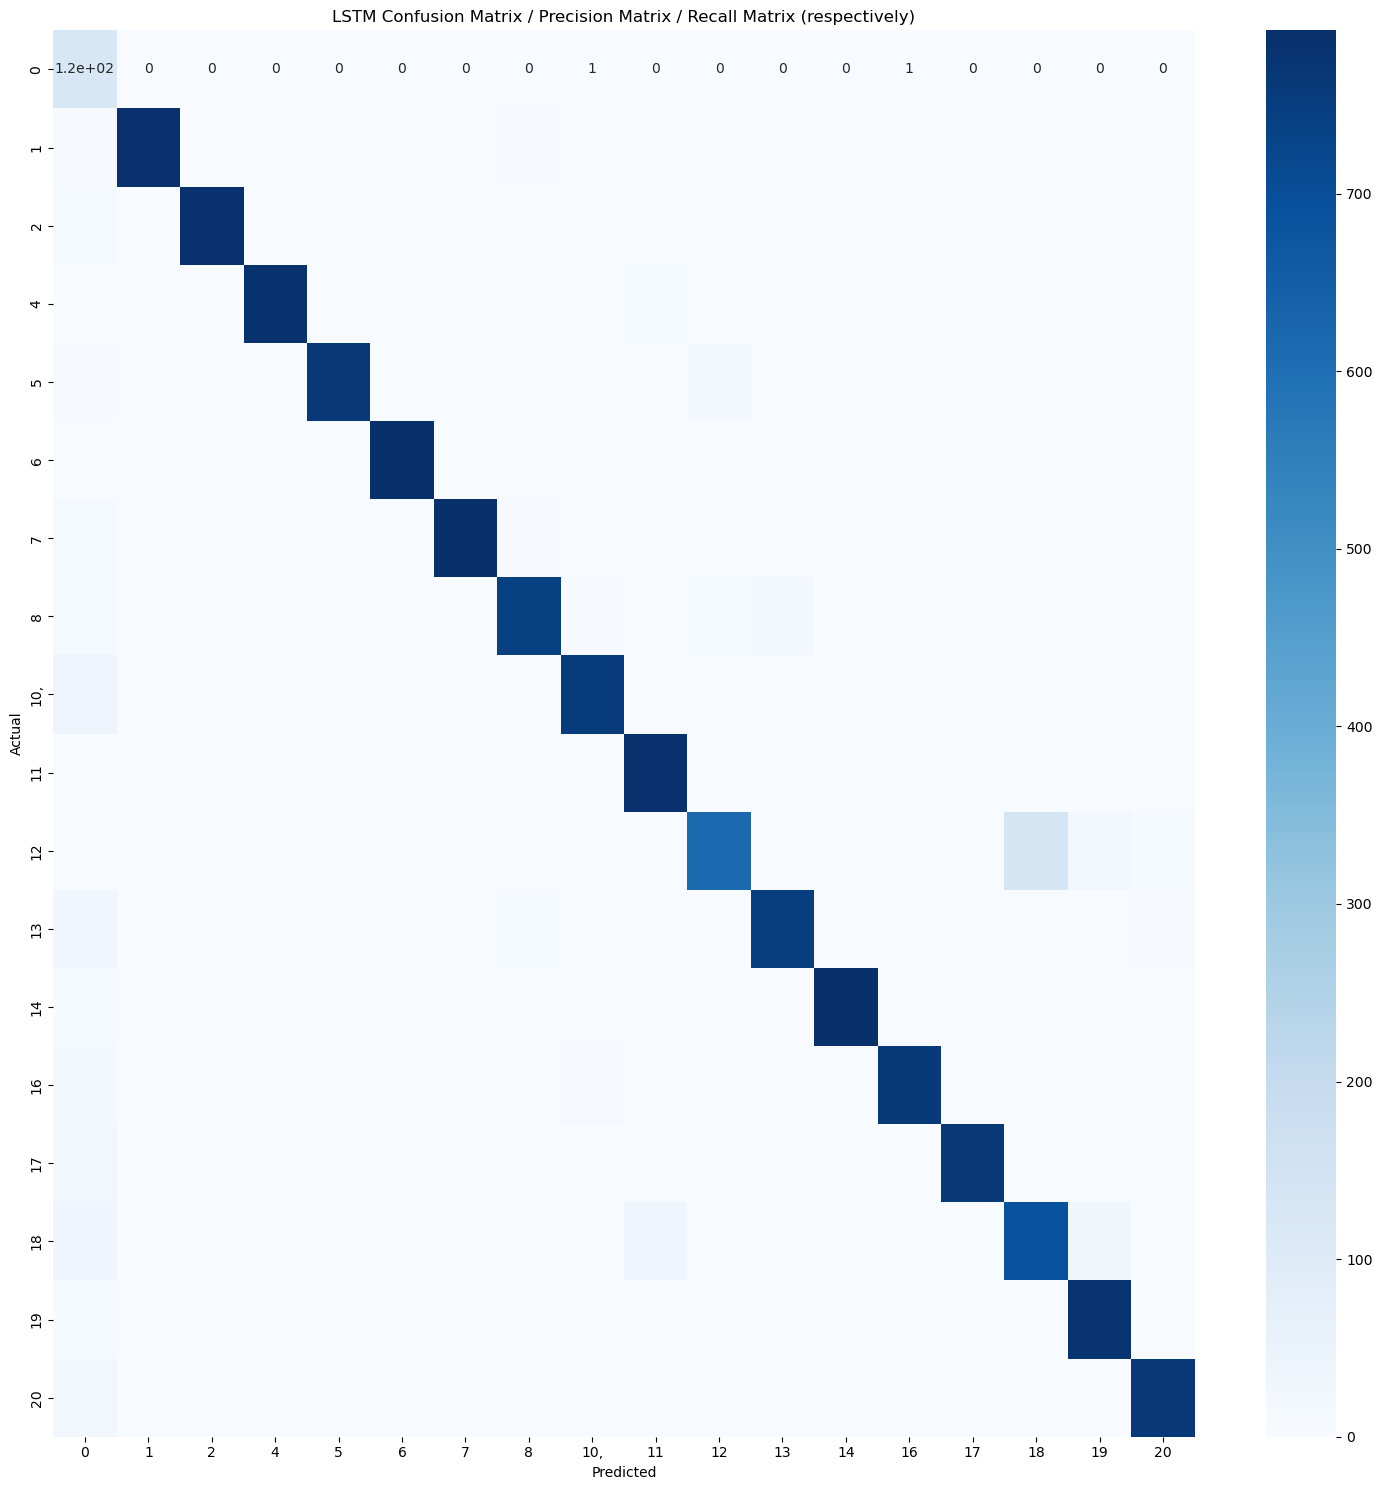

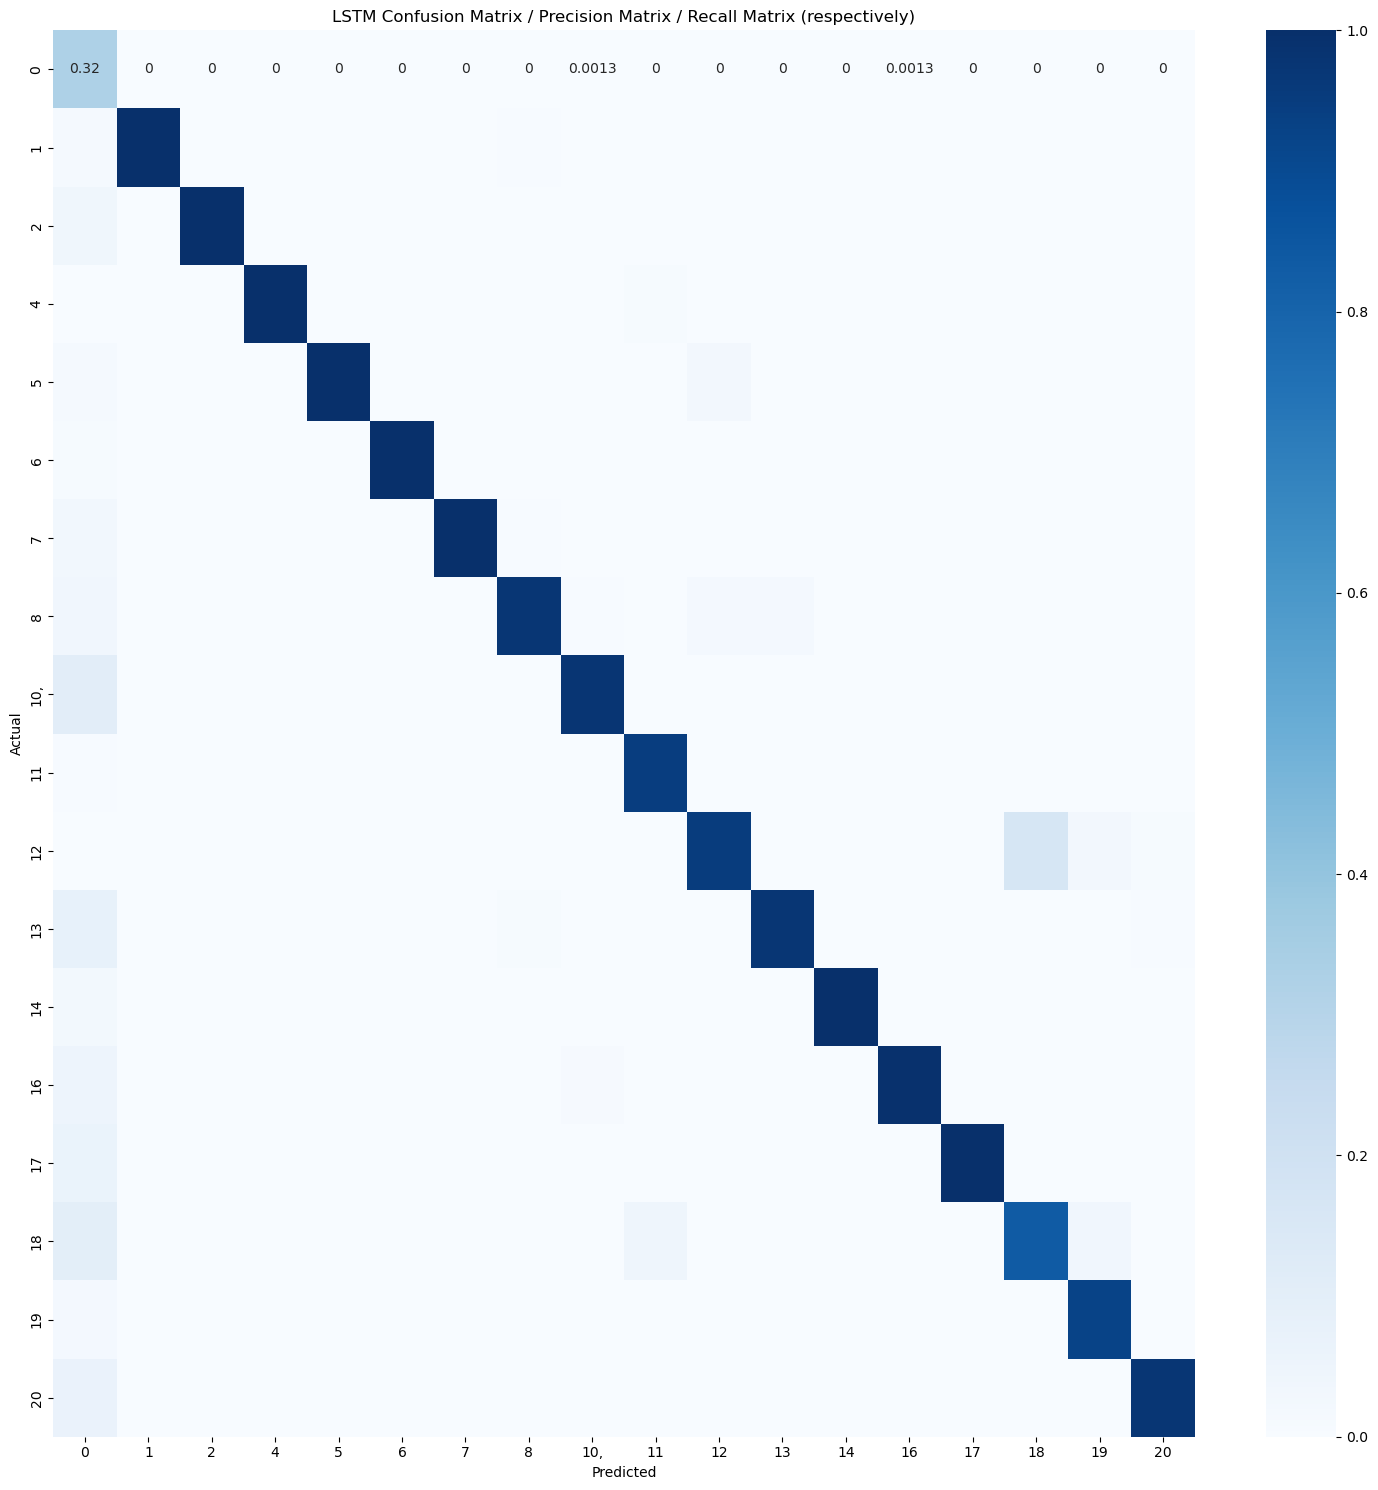

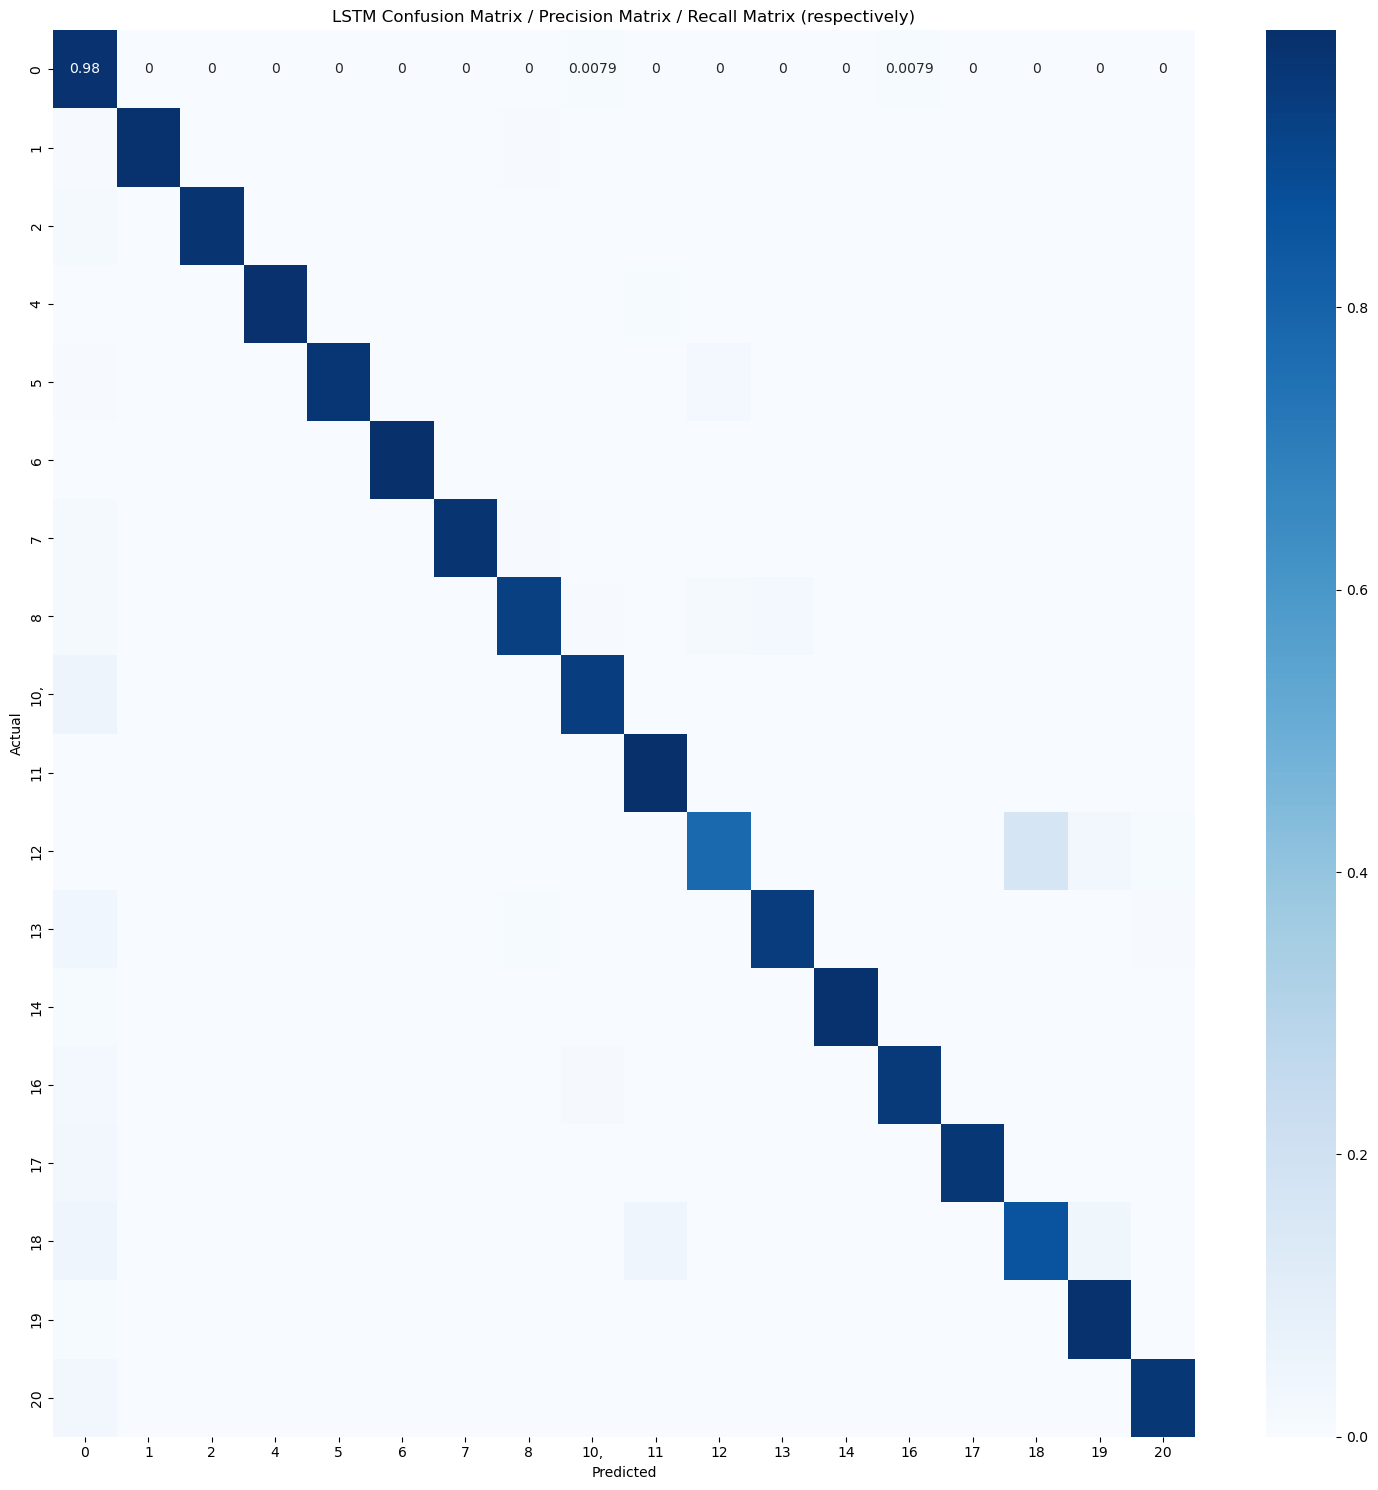

Aggregate Precision (including all classes): 0.938
Aggregate Precision (excluding class '0'): 0.974
Bidirectional LSTM integrated with ANN (More Faults) Classification accuracy_score: 0.9552184110231604


In [30]:
plot_confusion_matrix_1(y_true, y_pred, 'LSTM Confusion Matrix / Precision Matrix / Recall Matrix (respectively)')
print("Bidirectional LSTM integrated with ANN (More Faults) Classification accuracy_score:", accuracy_score(y_true, y_pred))